In [3]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from alibi_detect.od import SpectralResidual

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})

In [4]:
data_path = '../../../../data/train_data/host'
dfs = {}
for file in os.listdir(data_path):
    print('Reading ' + file)
    dfs[file[:-4]] = pd.read_csv(data_path+'/'+file) 

Reading dcos_docker.csv
Reading os_linux.csv
Reading db_oracle_11g.csv
Reading mw_redis.csv
Reading dcos_container.csv


In [6]:
print(dfs['dcos_docker']['cmdb_id'].unique())
print(dfs['dcos_docker']['name'].unique())

['docker_008' 'docker_003' 'docker_002' 'docker_005' 'docker_004'
 'docker_007' 'docker_001' 'docker_006']
['container_session_used' 'container_fgct' 'container_cpu_used'
 'container_thread_idle' 'container_thread_running'
 'container_thread_total' 'container_fgc' 'container_thread_used_pct'
 'container_mem_used']


In [53]:
df = dfs['os_linux']
df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']

# df = dfs['dcos_docker']
# df = df[df.name == 'container_cpu_used'][df.cmdb_id=='docker_003']
def get_past(df, curr_time, window_size):
    step_size = 1000*60
    df_new = pd.DataFrame(columns=['timestamp', 'value'])

    for time in [curr_time - step_size*x for x in range(window_size)][::-1]:
        if len(df[df.timestamp == time]) == 0:
            plug_time = np.max(df[df.timestamp < time]['timestamp'])
            row = {}
            row['timestamp'] = time
            row['value'] = df.loc[df.timestamp==plug_time, 'value'].values[0]
            df_new = df_new.append(row, ignore_index=True)
        else:
            row = {}
            row['timestamp'] = time
            row['value'] = df.loc[df.timestamp==time, 'value'].values[0]
            df_new = df_new.append(row, ignore_index=True)
    for time in [curr_time + step_size*x for x in range(5)]:
        row = {}
        row['timestamp'] = time
        value = np.mean(df_new['value'].values)
        df_new = df_new.append(row, ignore_index=True)
    print(len(df_new))
    return df_new

df = get_past(df, np.max(df.timestamp.unique()), len(df))

od = SpectralResidual(
    threshold=1,
    window_amp=40,
    window_local=40,
    n_est_points=1,
    n_grad_points=1
)

# od.infer_threshold(df['value'].values, threshold_perc=99.7)
lb = -60
ub = -5
print(od.threshold)
print(df['value'].values[lb:ub])
data = np.concatenate([df['value'].values[lb:ub], df['value'].values[lb:ub]])
inst_s = od.predict(data,return_instance_score=True)['data']
sns.lineplot(x=range(len(inst_s)),y=inst_s)
sns.lineplot(x=range(len(data)),y=data)
print(inst_s)

<ipython-input-53-d75d08c3f58e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']


1444
1
[0.67467  0.516088 0.428563 0.446497 0.421583 0.438188 0.400439 0.399082
 0.354432 0.440988 0.592407 0.868258 0.407601 0.427297 0.417635 0.431346
 0.407357 0.425947 0.392397 0.435218 0.394801 0.659414 0.382673 0.378203
 0.464185 0.393334 0.397764 0.430963 0.410509 0.436827 0.408742 0.65405
 0.406159 0.453187 0.407732 0.44916  0.396252 0.401835 0.401835 0.404374
 0.43823  0.687467 0.41702  0.411397 0.396219 0.426733 0.417281 0.415457
 0.425248 0.446106 0.446106 0.633738 0.455815 0.401768 0.40885 ]


ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [16]:
    print( od.predict(df['value'].values[:window_size])['data']['is_outlier'][-1])

{'data': {'instance_score': array([ 6.53679279e-01,  5.09057603e-01,  3.83271947e-01,  5.78411194e-01,
        4.85190802e-01,  3.99414445e-01,  1.42947273e+00,  1.87761030e-01,
        1.64056607e-01,  1.60338590e-01, -8.18464646e-03,  1.79537919e-01,
       -2.21522549e-02,  4.02268293e-02,  1.37016406e-01,  1.26743877e-01,
        7.27532529e-01, -8.19111725e-02, -1.89786879e-02, -7.92808474e-02,
       -1.93762283e-01, -2.31544107e-01, -3.05891056e-01, -1.55762534e-01,
       -5.71569457e-02, -1.34635773e-01, -3.27252626e-01,  5.85631216e-01,
       -1.40155344e-01, -2.28545521e-02, -1.29803797e-01, -1.76294347e-01,
        8.45315505e-01,  8.04273158e-01, -2.59913915e-02, -1.85918776e-01,
        3.94344102e-01, -1.09189669e-01, -1.47347502e-01, -1.84439133e-01,
       -6.48696867e-02, -1.38342293e-03, -1.51178518e-01, -1.49111111e-01,
       -3.24559776e-03, -5.91845398e-02,  4.61210187e-01, -1.96857236e-01,
       -1.54623643e-01, -1.17099821e-01, -5.58689422e-02, -1.32589985e-0

<ipython-input-8-d39ce934a421>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']


<AxesSubplot:xlabel='timestamp', ylabel='value'>

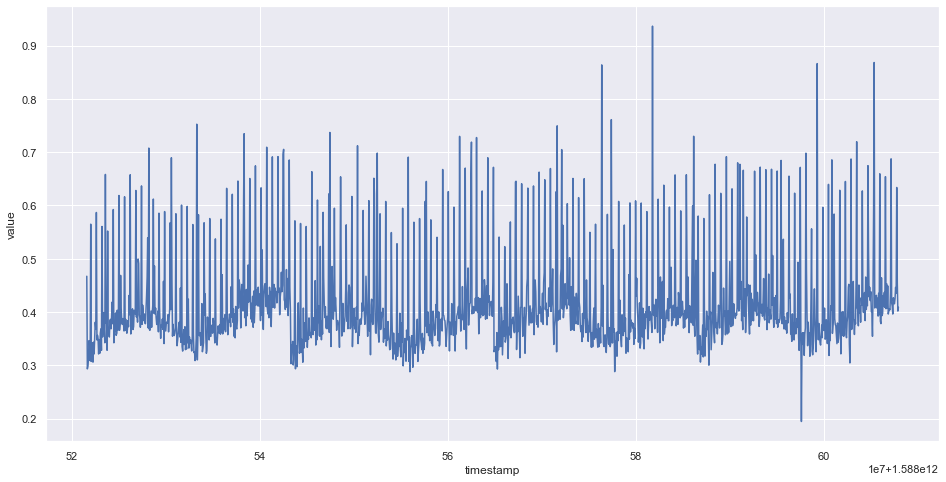

In [8]:
df = dfs['os_linux']
df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']
sns.lineplot(y='value',x='timestamp',data=df)